<a href="https://colab.research.google.com/github/MohnishBhardwaj2811/IPL-Analysis/blob/main/IPL_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

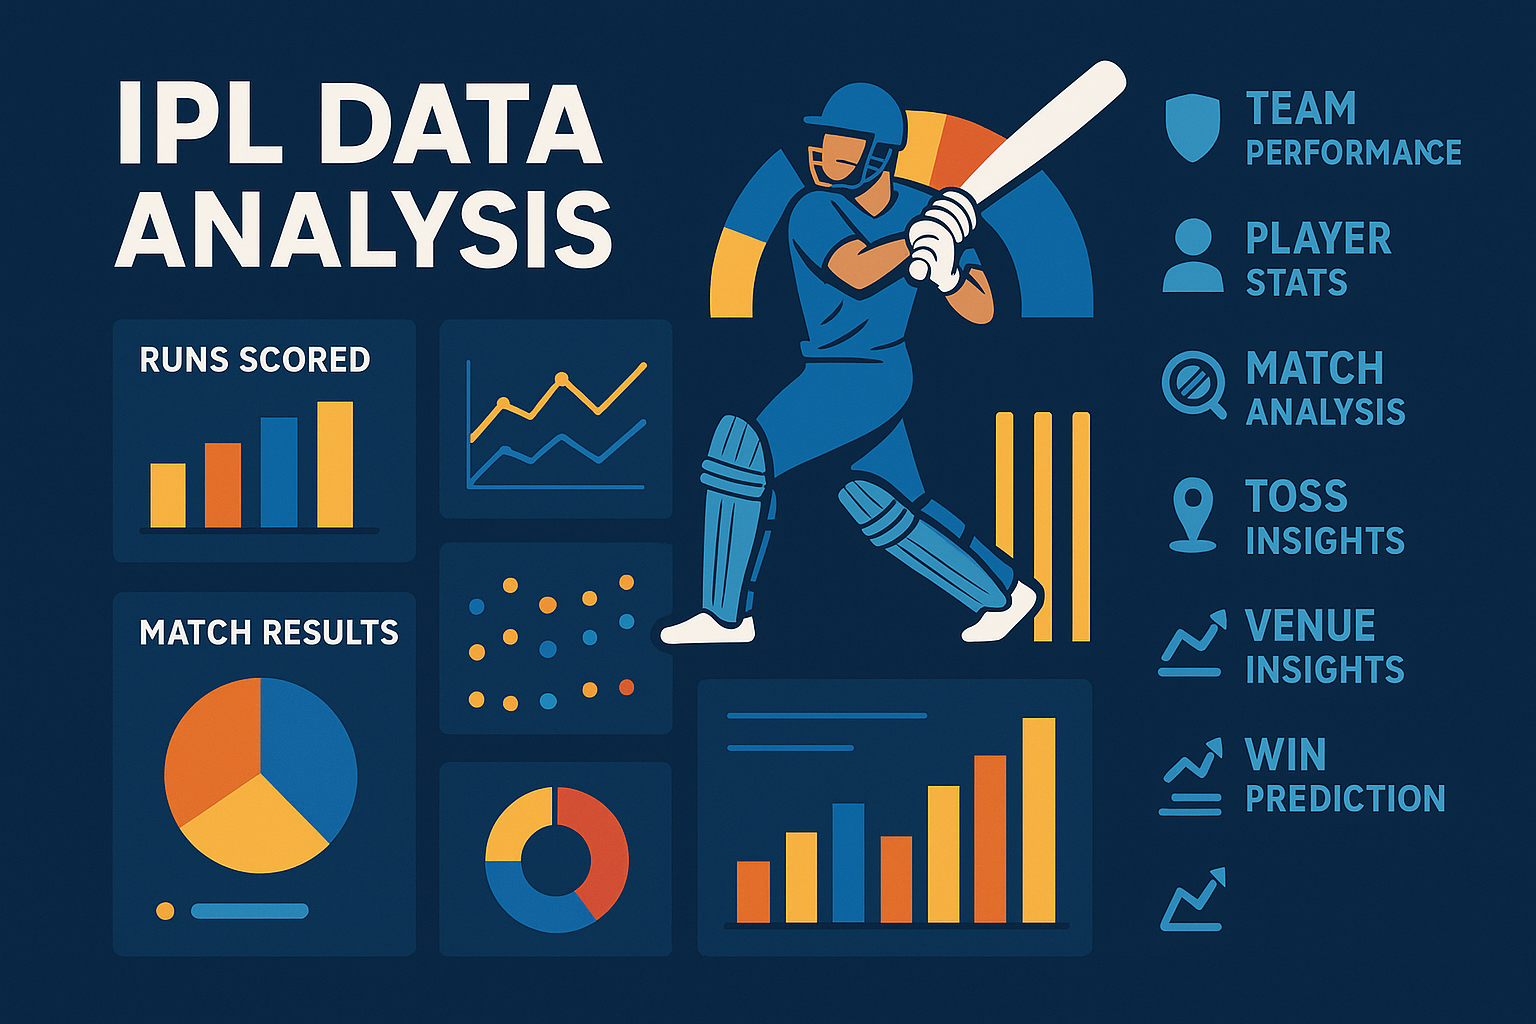

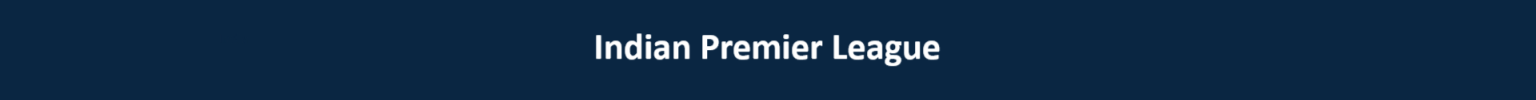

In [ ]:
# Importing Modules
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

# Importing display modules
from ipywidgets import interact, interactive, widgets, Layout
from IPython.display import display


In [ ]:
from cycler import cycler

# IPL-dashboard palette mapping
ipl_palette = {
    # UI layers
    "background_main":  {"hex": "#0A2642"},
    "tile_background":  {"hex": "#092E50"},

    # Text / iconography
    "text_primary":  {"hex": "#FFFFFF"},
    "text_accent":   {"hex": "#2F88B7"},

    # Data series
    "bar_primary":   {"hex": "#EAA43C"},
    "bar_secondary": {"hex": "#D97030"},
    "bar_tertiary":  {"hex": "#2F88B7"},

    # Outline / grid
    "outline":       {"hex": "#0A2642"},
}

# ─────────────────────────────────────────────────────────────
#  Custom theme setter
# ─────────────────────────────────────────────────────────────
def set_ipl_theme(pal: dict = ipl_palette) -> None:
    """
    Apply a dark-navy theme that matches the IPL dashboard artwork.
    Works for both Matplotlib and Seaborn.
    """
    # Convenience vars
    bg_main  = pal["background_main"]["hex"]
    bg_tile  = pal["tile_background"]["hex"]
    txt_prim = pal["text_primary"]["hex"]
    txt_acc  = pal["text_accent"]["hex"]
    outline  = pal["outline"]["hex"]

    # Colour cycle for data series
    data_cycle = [
        pal["bar_primary"]["hex"],
        pal["bar_secondary"]["hex"],
        pal["bar_tertiary"]["hex"]
    ]

    # ── Matplotlib rcParams ────────────────────────────────
    rc = {
        # Figure / axes face-colours
        "figure.facecolor":     bg_main,
        "axes.facecolor":       bg_tile,

        # Grid & spines
        "grid.color":           outline,
        "axes.edgecolor":       outline,

        # Text / ticks
        "text.color":           txt_prim,
        "axes.labelcolor":      txt_acc,
        "xtick.color":          txt_acc,
        "ytick.color":          txt_acc,

        # Font sizes
        "axes.titlesize":       14,
        "axes.labelsize":       12,
        "font.size":            11,

        # Colour cycle
        "axes.prop_cycle": cycler(color=data_cycle)
    }
    plt.rcParams.update(rc)

    # ── Seaborn global theme (inherits Matplotlib rc) ──────
    sns.set_theme(
        style="dark",           # minimal gridlines
        rc={
            "figure.facecolor": bg_main,
            "axes.facecolor":   bg_tile,
            "grid.color":       outline,
            "axes.labelcolor":  txt_acc,
            "xtick.color":      txt_acc,
            "ytick.color":      txt_acc,
        }
    )

# ─────────────────────────────────────────────────────────────
#  Example usage
# ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    set_ipl_theme()

In [ ]:
# Function

# Load Dataset

def batsman_statistics(dataframe: pd.DataFrame, batter_name: str, consistency_threshold: int = 30):
    bf = dataframe[dataframe["batter"] == batter_name].copy()

    # Core aggregates
    runs = int(bf["batsman_runs"].sum())

    legal_mask = ~bf["extras_type"].isin(["wides"])
    balls_faced = int(legal_mask.sum())

    strike_rate = (runs / balls_faced * 100) if balls_faced else np.nan

    # Boundaries
    fours = int((bf["batsman_runs"] == 4).sum())
    sixes = int((bf["batsman_runs"] == 6).sum())
    boundary_runs = fours * 4 + sixes * 6

    # Dot balls (legal + 0 runs off the bat)
    dot_balls = int((legal_mask & (bf["batsman_runs"] == 0)).sum())
    dot_ball_pct = (dot_balls / balls_faced * 100) if balls_faced else np.nan

    # Per‑match aggregates
    match_runs = bf.groupby("match_id")["batsman_runs"].sum()
    matches_played = len(match_runs)

    fifties = int(match_runs[(match_runs >= 50) & (match_runs < 100)].count())
    hundreds = int(match_runs[match_runs >= 100].count())
    fifties_hundreds = f"{fifties} / {hundreds}"

    high_score = int(match_runs.max()) if matches_played else np.nan
    runs_per_match = (runs / matches_played) if matches_played else np.nan

    # Consistency: % of matches with runs >= threshold
    consistency = (
        match_runs[match_runs >= consistency_threshold].count() / matches_played * 100
        if matches_played else np.nan
    )

    # Dismissal information
    outs_mask = (dataframe["is_wicket"] == 1) & (dataframe["player_dismissed"] == batter_name)
    outs = int(outs_mask.sum())
    batting_average = (runs / outs) if outs else np.nan

    dismissal_types = (
        dataframe[outs_mask]["dismissal_kind"].value_counts().to_dict()
    )

    # Derived metrics
    boundary_pct = (boundary_runs / runs * 100) if runs else np.nan

    # Simple custom impact metric: (Runs per Match) * Strike Rate
    batting_impact_score = runs_per_match * strike_rate if not np.isnan(runs_per_match) else np.nan

    return {
        "Runs Scored": runs,
        "Balls Faced": balls_faced,
        "Strike Rate": round(strike_rate, 2),
        "Batting Average": round(batting_average, 2) if not np.isnan(batting_average) else np.nan,
        "Fours": fours,
        "Sixes": sixes,
        "Dot Ball %": round(dot_ball_pct, 2),
        "50s / 100s": fifties_hundreds,
        "Dismissal Types": dismissal_types,
        "Consistency": round(consistency, 2),
        "Boundary %": round(boundary_pct, 2),
        "Runs per Match": round(runs_per_match, 2),
        "High Score": high_score,
        "Batting Impact Score": round(batting_impact_score, 2),
    }


def bowler_statistics(df: pd.DataFrame, bowler_name: str):
    """
    Return a dict of advanced bowling metrics for `bowler_name`.
    """
    bdf = df[df["bowler"] == bowler_name].copy()
    bdf["extras_type"] = bdf["extras_type"].fillna("")

    # Legal deliveries
    legal_mask  = ~bdf["extras_type"].isin(["wides", "noballs"])
    legal_balls = int(legal_mask.sum())
    overs_float = legal_balls / 6

    # Wickets credited to bowler
    credited_kinds = {
        "bowled", "caught", "caught and bowled", "lbw",
        "stumped", "hit wicket", "hit-wicket", "caught & bowled"
    }
    wkt_mask = (bdf["is_wicket"] == 1) & (bdf["dismissal_kind"].isin(credited_kinds))
    wickets  = int(wkt_mask.sum())

    runs_conceded = int(bdf["total_runs"].sum())
    economy       = runs_conceded / overs_float if overs_float else np.nan
    bowl_avg      = runs_conceded / wickets if wickets else np.nan
    strike_rate   = legal_balls / wickets if wickets else np.nan

    # Dot‑ball %
    dots    = int((legal_mask & (bdf["total_runs"] == 0)).sum())
    dot_pct = dots / legal_balls * 100 if legal_balls else np.nan

    # Maiden overs
    over_totals  = bdf.groupby(["match_id", "inning", "over"])["total_runs"].sum()
    maiden_overs = int((over_totals == 0).sum())

    # Best bowling in a single match-inning
    inn_wkts = bdf.groupby(["match_id", "inning"])["dismissal_kind"].apply(
        lambda x: x.isin(credited_kinds).sum())
    inn_runs = bdf.groupby(["match_id", "inning"])["total_runs"].sum()

    df_best = pd.concat([inn_wkts, inn_runs], axis=1, keys=["wkts", "runs"])

    if not df_best.empty:
        best_row = df_best.sort_values(["wkts", "runs"], ascending=[False, True]).iloc[0]
        best_figs = f"{int(best_row.wkts)}/{int(best_row.runs)}"
    else:
        best_figs = "0/0"

    # Hauls
    four_fers = int((inn_wkts == 4).sum())
    five_fers = int((inn_wkts >= 5).sum())

    # Extras
    wides    = int((bdf["extras_type"] == "wides").sum())
    no_balls = int((bdf["extras_type"] == "noballs").sum())

    # Custom impact score
    impact = (wickets * 24) / (economy + 1) if not np.isnan(economy) and economy != -1 else np.nan

    return {
        "Wickets Taken": wickets,
        "Overs Bowled": round(overs_float, 2),
        "Economy Rate": round(economy, 2),
        "Bowling Average": round(bowl_avg, 2) if wickets else np.nan,
        "Bowling Strike Rate": round(strike_rate, 2) if wickets else np.nan,
        "Dot Ball %": round(dot_pct, 2),
        "Maiden Overs": maiden_overs,
        "Best Bowling Figures": best_figs,
        "4-Wicket Hauls": four_fers,
        "5-Wicket Hauls": five_fers,
        "Wide Balls": wides,
        "No Balls": no_balls,
        "Runs Conceded": runs_conceded,
        "Bowling Impact Score": round(impact, 2) if not np.isnan(impact) else np.nan,
    }



def feilder_statistics(df: pd.DataFrame, fielder_name: str):
    """
    Return a dict of fielding metrics for `fielder_name`.
    """
    df["fielder"] = df["fielder"].fillna("")
    fmask = df["fielder"] == fielder_name

    catches   = int(((df["dismissal_kind"].isin(["caught", "caught and bowled"])) & fmask).sum())
    run_outs  = int(((df["dismissal_kind"] == "run out") & fmask).sum())
    stumpings = int(((df["dismissal_kind"] == "stumped") & fmask).sum())

    # If you have a separate 'direct_hit' flag, use it here; else treat run‑outs as direct hits
    direct_hits = run_outs
    dismissals  = catches + run_outs + stumpings

    impact = catches * 8 + run_outs * 12 + stumpings * 10  # tweak weights freely

    return {
        "Catches": catches,
        "Run Outs": run_outs,
        "Stumpings": stumpings,
        "Direct Hits": direct_hits,
        "Dismissals Involved": dismissals,
        "Fielding Impact Score": impact,
    }


def highest_match_score(deliv_df: pd.DataFrame, matches_df: pd.DataFrame, batter: str):
    """
    Return a dictionary with the batter's highest IPL score
    (single match) plus contextual info.
    """
    bdf = deliv_df[deliv_df["batter"] == batter]
    if bdf.empty:
        raise ValueError(f"No deliveries found for batter '{batter}'")

    # Total runs per match_id
    match_totals = bdf.groupby("match_id")["batsman_runs"].sum()

    top_match_id = match_totals.idxmax()
    top_runs     = int(match_totals.loc[top_match_id])

    # Subset rows for that match only
    top_bdf = bdf[bdf["match_id"] == top_match_id]

    # Balls faced (exclude wides & no-balls)
    balls = int((~top_bdf["extras_type"].isin(["wides", "noballs"])).sum())
    sr    = round(top_runs / balls * 100, 2) if balls else np.nan

    # Boundaries
    fours = int((top_bdf["batsman_runs"] == 4).sum())
    sixes = int((top_bdf["batsman_runs"] == 6).sum())

    # Match metadata
    meta = matches_df[matches_df["id"] == top_match_id].iloc[0]
    date  = meta["date"]
    city  = meta["city"]
    venue = meta["venue"]
    batting_team = top_bdf["batting_team"].iloc[0]
    opponent = meta["team1"] if meta["team1"] != batting_team else meta["team2"]

    return {
        "Batter": batter,
        "Runs": top_runs,
        "Balls": balls,
        "Strike Rate": sr,
        "Fours": fours,
        "Sixes": sixes,
        "Match ID": int(top_match_id),
        "Date": date,
        "City": city,
        "Venue": venue,
        "Batting Team": batting_team,
        "Opponent": opponent,
    }




def all_players_as_list(deliveries_df):
    """
    Return a **list** containing every distinct player name that appears
    in the IPL deliveries data—taken from the columns
    'batter', 'bowler', and 'non_striker'.

    • Any missing (NaN) entries are ignored.
    • The function returns the names **sorted alphabetically**
      (remove the sorted() wrapper if you prefer the raw order).
    """
    cols = ["batter", "bowler", "non_striker"]

    # Use a Python set for uniqueness, then convert to list
    unique_names = (
        pd.concat([deliveries_df[c] for c in cols])   # stack the 3 columns
          .dropna()                                   # ditch NaNs
          .unique()                                   # NumPy array of uniques
    )

    return sorted(unique_names)     # turn into an alphabetically‑sorted list

def extract_team_names(deliv_df, matches_df=None):
    """
    Return an alphabetically‑sorted list of all unique IPL team names found in:

      • deliveries columns:  'batting_team', 'bowling_team'
      • matches columns (optional):  'team1', 'team2'

    Parameters
    ----------
    deliv_df   : pandas.DataFrame
        The deliveries data frame (mandatory).
    matches_df : pandas.DataFrame or None
        The matches data frame (optional – pass it if you have it).

    Example
    -------
    teams = extract_team_names(deliveries, matches)
    """
    team_set = set()

    # From deliveries.csv
    for col in ["batting_team", "bowling_team"]:
        if col in deliv_df.columns:
            team_set.update(deliv_df[col].dropna().unique())

    # From matches.csv (if supplied)
    if matches_df is not None:
        for col in ["team1", "team2"]:
            if col in matches_df.columns:
                team_set.update(matches_df[col].dropna().unique())

    return sorted(team_set)


def team_season_stats(deliv_df: pd.DataFrame, matches_df: pd.DataFrame, team: str):
    team_matches = matches_df[(matches_df["team1"] == team) | (matches_df["team2"] == team)].copy()
    if team_matches.empty:
        raise ValueError(f"No matches found for team '{team}'")

    season_map = matches_df.set_index("id")["season"]
    deliv_df = deliv_df.copy()
    deliv_df["season"] = deliv_df["match_id"].map(season_map)

    stats = []

    for season, mdf in team_matches.groupby("season"):
        matches_played = len(mdf)
        wins = int((mdf["winner"] == team).sum())
        ties_no_result = int(((mdf["winner"].isna()) | (mdf["winner"] == "")).sum())
        losses = matches_played - wins - ties_no_result
        win_pct = wins / matches_played * 100 if matches_played else np.nan

        sdeliv = deliv_df[deliv_df["season"] == season]
        bat_df = sdeliv[sdeliv["batting_team"] == team]
        bowl_df = sdeliv[sdeliv["bowling_team"] == team]

        runs_for = int(bat_df["total_runs"].sum())
        runs_against = int(bowl_df["total_runs"].sum())
        legal_bat_balls = int((bat_df["extras_type"] != "wides").sum())
        legal_bowl_balls = int((bowl_df["extras_type"] != "wides").sum())

        overs_for = legal_bat_balls / 6 if legal_bat_balls else np.nan
        overs_against = legal_bowl_balls / 6 if legal_bowl_balls else np.nan

        nrr = (runs_for / overs_for - runs_against / overs_against) if overs_for and overs_against else np.nan

        stats.append({
            "Season": str(season),
            "Matches": matches_played,
            "Wins": wins,
            "Losses": losses,
            "WinPct": round(win_pct, 2),
            "RunsScored": runs_for,
            "RunsConceded": runs_against,
            "AvgRunsFor": round(runs_for / matches_played, 2),
            "AvgRunsAgainst": round(runs_against / matches_played, 2),
            "NetRunRate": round(nrr, 3) if not np.isnan(nrr) else np.nan,
        })

    return pd.DataFrame(stats).set_index("Season").sort_index()


def overall_batsman(deliveries_df: pd.DataFrame,
                    matches_df: pd.DataFrame,
                    season: str | None = "all") -> pd.DataFrame:
    """
    Return a DataFrame of the TOP-10 run-scorers.

    Parameters
    ----------
    deliveries_df : DataFrame   (IPL deliveries.csv)
    matches_df    : DataFrame   (IPL matches.csv)
    season        : str or None
        • "all" / "all season" / None  → overall (all seasons combined)
        • "2013", "2009/10", …         → that specific season only

    Columns returned
    ----------------
      Player • Runs • Balls • StrikeRate
    """
    d = deliveries_df.copy()
    d["extras_type"] = d["extras_type"].fillna("")

    # Attach season to each delivery
    season_lookup = matches_df.set_index("id")["season"]
    d["season"] = d["match_id"].map(season_lookup)

    # Optional season filter
    if season and str(season).lower() not in {"all", "all season"}:
        d = d[d["season"] == season]

    # Aggregate
    legal_mask = ~d["extras_type"].isin(["wides", "noballs"])
    agg = (
        d.assign(legal_ball=legal_mask.astype(int))
         .groupby("batter")
         .agg(Runs=("batsman_runs", "sum"),
              Balls=("legal_ball", "sum"))
         .reset_index()
         .rename(columns={"batter": "Player"})
    )
    agg["StrikeRate"] = (agg["Runs"] / agg["Balls"] * 100).round(2)

    # Top-10
    top10 = agg.sort_values("Runs", ascending=False).head(10).reset_index(drop=True)
    return top10



def overall_bowler(deliveries_df: pd.DataFrame,
                   matches_df: pd.DataFrame,
                   season: str | None = "all") -> pd.DataFrame:
    """
    Return a DataFrame of the TOP-10 wicket-takers.

    Parameters
    ----------
    deliveries_df : DataFrame   (IPL deliveries.csv)
    matches_df    : DataFrame   (IPL matches.csv)
    season        : str or None
        • "all" / "all season" / None  → overall (all seasons combined)
        • "2013", "2009/10", …         → that specific season only

    Columns returned
    ----------------
      Player • Wickets • Overs • RunsConceded • Economy • Average • StrikeRate
    """
    d = deliveries_df.copy()
    d["extras_type"] = d["extras_type"].fillna("")

    # Map season to each delivery
    season_lookup = matches_df.set_index("id")["season"]
    d["season"] = d["match_id"].map(season_lookup)

    # Optional season filter
    if season and str(season).lower() not in {"all", "all season"}:
        d = d[d["season"] == season]

    # Only wickets credited to bowler
    credited = {
        "bowled", "caught", "caught and bowled", "lbw",
        "stumped", "hit wicket", "hit-wicket", "caught & bowled"
    }
    wkt_rows = d[(d["is_wicket"] == 1) & (d["dismissal_kind"].isin(credited))]

    # Aggregate base metrics
    legal_mask = ~d["extras_type"].isin(["wides", "noballs"])
    bowl_base = (
        d.assign(legal_ball=legal_mask.astype(int))
          .groupby("bowler")
          .agg(RunsConceded=("total_runs", "sum"),
               LegalBalls=("legal_ball", "sum"))
    )

    wickets = wkt_rows.groupby("bowler").size().rename("Wickets")
    agg = bowl_base.join(wickets, how="left").fillna({"Wickets": 0})

    # Derived metrics
    agg["Overs"] = agg["LegalBalls"] / 6
    agg["Economy"] = (agg["RunsConceded"] / agg["Overs"]).round(2)
    agg["Average"] = (agg["RunsConceded"] / agg["Wickets"]).replace([np.inf, np.nan], 0).round(2)
    agg["StrikeRate"] = (agg["LegalBalls"] / agg["Wickets"]).replace([np.inf, np.nan], 0).round(2)

    agg = (
        agg.reset_index()
           .rename(columns={"bowler": "Player"})
           .astype({"Wickets": "int", "RunsConceded": "int"})
    )

    top10 = agg.sort_values("Wickets", ascending=False).head(10).reset_index(drop=True)
    return top10[["Player", "Wickets", "Overs", "RunsConceded", "Economy", "Average", "StrikeRate"]]


# orange cap



# ──────────────────────────────────────────────────────────
#  ORANGE-CAP TABLE  (highest run-scorer per season)
# ──────────────────────────────────────────────────────────
def orange_cap_table(deliveries_df: pd.DataFrame, matches_df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame listing the IPL Orange-Cap winner (most runs) for every season.

    Columns returned:
      Season • Player • Runs
    """
    d = deliveries_df.copy()
    d["extras_type"] = d["extras_type"].fillna("")

    # Attach season to each delivery
    season_map = matches_df.set_index("id")["season"]
    d["season"] = d["match_id"].map(season_map)

    # Season-wise run totals
    season_runs = (
        d.groupby(["season", "batter"])["batsman_runs"].sum()
          .reset_index()
    )

    # Pick top run-scorer per season
    orange = (
        season_runs.sort_values(["season", "batsman_runs"], ascending=[True, False])
                   .groupby("season").head(1)      # one row per season
                   .rename(columns={"batter": "Player", "batsman_runs": "Runs"})
                   .reset_index(drop=True)
    )

    return orange[["season", "Player", "Runs"]].rename(columns={"season": "Season"})


# ──────────────────────────────────────────────────────────
#  PURPLE-CAP TABLE  (highest wicket-taker per season)
# ──────────────────────────────────────────────────────────
def purple_cap_table(deliveries_df: pd.DataFrame, matches_df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame listing the IPL Purple-Cap winner (most wickets) for every season.

    Columns returned:
      Season • Player • Wickets
    """
    d = deliveries_df.copy()
    d["extras_type"] = d["extras_type"].fillna("")

    season_map = matches_df.set_index("id")["season"]
    d["season"] = d["match_id"].map(season_map)

    # Only wickets credited to the bowler
    credited_kinds = {
        "bowled", "caught", "caught and bowled", "lbw",
        "stumped", "hit wicket", "hit-wicket", "caught & bowled"
    }
    wkt_rows = d[(d["is_wicket"] == 1) & (d["dismissal_kind"].isin(credited_kinds))]

    season_wkts = (
        wkt_rows.groupby(["season", "bowler"]).size()
                .reset_index(name="Wickets")
    )

    purple = (
        season_wkts.sort_values(["season", "Wickets"], ascending=[True, False])
                   .groupby("season").head(1)
                   .rename(columns={"bowler": "Player"})
                   .reset_index(drop=True)
    )

    return purple[["season", "Player", "Wickets"]].rename(columns={"season": "Season"})





# ------------------ Plotting Function ------------------

def plot_player(batting_stats: dict,
                bowling_stats: dict,
                fielding_stats: dict,
                best_innings: dict) -> None:
    """
    Render a two-column ‘player snapshot’ dashboard from four stats dictionaries.

    dict1 - batting_stats
    dict2 - bowling_stats
    dict3 - fielding_stats
    dict4 - best_innings
    """
    # ── Figure grid ────────────────────────────────────────────────
    fig = plt.figure(figsize=(12, 14), tight_layout=True)
    gs  = fig.add_gridspec(
            nrows=4, ncols=2,
            height_ratios=[3, 2, 2, 2],
            width_ratios=[2, 2],
            hspace=.7, wspace=.6)

    # ── 1) Radar (batting profile) ────────────────────────────────
    radar_metrics = ['Strike Rate', 'Batting Average', 'Boundary %',
                     'Dot Ball %', 'Runs per Match', 'Consistency']
    radar_vals = [batting_stats.get(m, 0) for m in radar_metrics]
    angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
    radar_vals += radar_vals[:1]
    angles     += angles[:1]
    ax_radar = fig.add_subplot(gs[0, 0], polar=True)
    ax_radar.plot(angles, radar_vals, lw=2)
    ax_radar.fill(angles, radar_vals, alpha=.25)
    ax_radar.set_thetagrids(np.degrees(angles[:-1]), radar_metrics, fontsize=8)
    ax_radar.set_title("Batting Radar", y=1.15, fontsize=11)

    # ── 2) Donut (dismissals) ─────────────────────────────────────
    dismissals = batting_stats.get('Dismissal Types', {})
    lab, siz = list(dismissals.keys()), list(dismissals.values())
    ax_donut = fig.add_subplot(gs[0, 1])
    wedges, _ = ax_donut.pie(siz, startangle=90, wedgeprops=dict(width=.35))
    ax_donut.legend(wedges, lab, bbox_to_anchor=(1.05, .9), fontsize=7)
    ax_donut.set_title("Dismissal Breakdown", fontsize=11)

    # ── 3) Stacked bar (boundary runs) ────────────────────────────
    runs_four = batting_stats.get('Fours', 0)*4
    runs_six  = batting_stats.get('Sixes', 0)*6
    runs_tot  = batting_stats.get('Runs Scored', 0)
    runs_other = runs_tot - runs_four - runs_six
    ax_stack = fig.add_subplot(gs[1, 0])
    ax_stack.barh(['Runs'], runs_four, color='#1f77b4', label='Fours')
    ax_stack.barh(['Runs'], runs_six, left=runs_four, color='#ff7f0e', label='Sixes')
    ax_stack.barh(['Runs'], runs_other, left=runs_four+runs_six,
                  color='#cccccc', label='Other')
    ax_stack.set_xlabel('Total Runs')
    ax_stack.set_title("Boundary Contribution", fontsize=11)
    ax_stack.legend(frameon=False)

    # ── 4) Lollipop (50s vs 100s) ─────────────────────────────────
    fifty_hundred = batting_stats.get('50s / 100s', '0/0').replace(' ', '')
    fifties, hundreds = map(int, fifty_hundred.split('/'))
    ax_lolli = fig.add_subplot(gs[1, 1])
    #ax_lolli.stem([0, 1], [fifties, hundreds], use_line_collection=True)
    ax_lolli.stem([0, 1], [fifties, hundreds])
    ax_lolli.set_xticks([0, 1]); ax_lolli.set_xticklabels(['50s', '100s'])
    ax_lolli.set_ylim(0, max(fifties, hundreds)*1.2 + 1)
    for x, y in zip([0, 1], [fifties, hundreds]):
        ax_lolli.text(x, y+0.5, y, ha='center')
    ax_lolli.set_title("Milestones (50s & 100s)", fontsize=11)
    ax_lolli.spines[['top','right']].set_visible(False)

    # ── 5) Fielding bars ──────────────────────────────────────────
    field_bars = {'Catches': fielding_stats.get('Catches', 0),
                  'Direct Hits': fielding_stats.get('Direct Hits', 0),
                  'Run Outs': fielding_stats.get('Run Outs', 0)}
    ax_field = fig.add_subplot(gs[2, 0])
    ax_field.barh(list(field_bars.keys()), list(field_bars.values()), color='#2ca02c')
    ax_field.set_xlabel('Count')
    ax_field.set_title("Key Fielding Contributions", fontsize=11)

    # ── 6) KPI badges ─────────────────────────────────────────────
    ax_kpi = fig.add_subplot(gs[2, 1]); ax_kpi.axis('off')
    ax_kpi.text(0, .8, "Bowling", fontsize=9, weight='bold')
    ax_kpi.text(0.05, .65,
                f"Overs: {bowling_stats.get('Overs Bowled',0):.2f}\n"
                f"Econ : {bowling_stats.get('Economy Rate',0):.1f}",
                fontsize=9, va='top')
    ax_kpi.text(0, .45, "Extras", fontsize=9, weight='bold')
    ax_kpi.text(0.05, .34,
                f"Wides: {bowling_stats.get('Wide Balls',0)}\n"
                f"No-Balls: {bowling_stats.get('No Balls',0)}",
                fontsize=9, va='top')
    ax_kpi.text(0, .15, "Field Impact Score", fontsize=9, weight='bold')
    ax_kpi.text(0.05, .04, fielding_stats.get('Fielding Impact Score',0),
                fontsize=18, weight='bold', color='#d62728')

    # ── 7) Best-innings card ──────────────────────────────────────
    ax_card = fig.add_subplot(gs[3, :]); ax_card.axis('off')
    card_txt = (
        f"⭐  BEST INNINGS  ⭐\n\n"
        f"{best_innings.get('Batter','')} – {best_innings.get('Runs',0)}* "
        f"({best_innings.get('Balls',0)}b)\n"
        f"SR {best_innings.get('Strike Rate',0)} | 4s {best_innings.get('Fours',0)} "
        f"  6s {best_innings.get('Sixes',0)}\n\n"
        f"{best_innings.get('Batting Team','')} vs {best_innings.get('Opponent','')}\n"
        f"{best_innings.get('Venue','')}  –  {best_innings.get('Date','')}"
    )
    ax_card.text(.5, .5, card_txt, ha='center', va='center',
                 fontsize=11, bbox=dict(boxstyle='round', fc='#f7f7f7', ec='grey'))

    player_name = best_innings.get('Batter', 'Player')
    plt.suptitle(f"{player_name} – Career Snapshot", fontsize=14, weight='bold', y=.95)
    plt.show()

In [ ]:
#Plotting Function

def Team_graph_plot(team_name="Mumbai Indians") -> None:
    data = team_season_stats(delivieres_dataset, matches_dataset, team_name)
    display(data)

    # Season is in index; move it to a column
    data = data.reset_index()


    # run scored vs run conceded
    # Melt the DataFrame
    df_long = data.melt(id_vars="Season",value_vars=["RunsScored", "RunsConceded"],var_name="Metric",value_name="Runs")

    # Plot
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_long, x="Season", y="Runs", hue="Metric", marker="o", linewidth=2.2)

    plt.title(f"{team_name} – Runs Scored vs. Conceded by Season")
    plt.ylabel("Total Runs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    # Avg run for vs Avg Runs Against
    # Melt the DataFrame
    data = data.reset_index()
    long_df = data.melt(id_vars="Season",
                        value_vars=["AvgRunsFor","AvgRunsAgainst"],
                        var_name="Metric",
                        value_name="Runs")

    # 3️⃣  bar plot (dodge=True ➜ side-by-side)
    plt.figure(figsize=(9, 5))
    sns.barplot(data=long_df, x="Season", y="Runs",
                hue="Metric", palette=["#eaa43c", "#d97030"], dodge=True)

    plt.title(f"{team_name} – Runs Scored vs. Conceded by Season")
    plt.ylabel("Total Runs")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    #season win pct

    plt.figure(figsize=(8, 4))
    ax = plt.gca()

    sns.barplot( data=data, y="Season", x="WinPct", linewidth=1.2,ax=ax)

    ax.set_title("Win Percentage by Season")
    ax.set_xlabel("Win %")
    ax.set_ylabel("Season")
    ax.set_xlim(0, 100)     # WinPct is a percentage
    plt.tight_layout()
    plt.show()

    # Net run rate

    sns.barplot(data=data, x="Season", y="NetRunRate")   # one bar per category
    plt.title("NetRunRate")
    plt.ylabel("Season")
    plt.tight_layout()
    plt.show()

    # matches win /looses
    df = data
    vals_win  =  df["Wins"].values
    vals_loss = -df["Losses"].values
    seasons   =  df["Season"].astype(str).values

    y = range(len(df))           # y-axis positions

    fig, ax = plt.subplots(figsize=(8, 0.6*len(df)))

    # Plot losses (left) & wins (right)
    ax.barh(y, vals_loss)
    ax.barh(y, vals_win )

    # Season labels centred at x=0 with padding
    for y_pos, season in zip(y, seasons):
        ax.text(0, y_pos, season, ha="center", va="center",
                fontsize=9, color="white",
                bbox=dict(boxstyle="round,pad=0.3",
                          fc="#0a2642", ec="#0a2642"))

    # Formatting
    ax.set_yticks([])                 # hide y-axis
    ax.set_xlabel("Matches")
    ax.axvline(0, color="black")      # centre line
    ax.set_title("Wins vs Losses by Season (Divergent View)")
    plt.tight_layout()
    plt.show()



# ────────────────────────────────────────────────
#  Helper: Horizontal bar plot for any stat-dict DF
# ────────────────────────────────────────────────
def bar_plot(statistic_df: pd.DataFrame, exclude: set[str], title: str) -> None:
    row = statistic_df.iloc[0]
    metrics, scores = [], []

    for k, v in row.items():
        if k in exclude:
            continue
        try:
            scores.append(float(v))
            metrics.append(k)
        except ValueError:
            pass  # skip non-numeric

    plot_df = pd.DataFrame({"Metric": metrics, "Value": scores})
    plt.figure(figsize=(8, 4))
    sns.barplot(data=plot_df, y="Metric", x="Value",
                color="#eaa43c", edgecolor="black", linewidth=0.8)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# ────────────────────────────────────────────────
#  Helper: Tiny KPI card
# ────────────────────────────────────────────────
def kpi_card(title: str, kpis: dict) -> widgets.VBox:
    title_html = widgets.HTML(
        f"<b style='font-size:15px'>{title}</b>",
        layout=widgets.Layout(margin="0 0 8px 0")
    )
    rows = [
        widgets.HTML(
            f"<div style='display:flex;justify-content:space-between;'>"
            f"<span>{k}</span><span><b>{v}</b></span></div>"
        )
        for k, v in kpis.items()
    ]
    return widgets.VBox(
        [title_html] + rows,
        layout=widgets.Layout(
            padding="10px 14px",
            border="1px solid #ccc",
            border_radius="10px",
            box_shadow="2px 2px 6px rgba(0,0,0,.15)",
            background_color="#f9fafb",
            width="230px"
        )
    )

# ────────────────────────────────────────────────
#  Main dashboard
# ────────────────────────────────────────────────
def player_stats_graph(player="V Kohli") -> None:
    bat_df  = pd.DataFrame([batsman_statistics(delivieres_dataset, player)])
    bowl_df = pd.DataFrame([bowler_statistics(delivieres_dataset, player)])
    fld_df  = pd.DataFrame([feilder_statistics(delivieres_dataset, player)])
    top_inn = highest_match_score(delivieres_dataset, matches_dataset, player)

    display(bat_df, bowl_df, fld_df, pd.DataFrame([top_inn]))

    # Divergent bars  ➜  Runs vs Balls
    diff_runs = bat_df["Runs Scored"].iloc[0]
    diff_balls = bat_df["Balls Faced"].iloc[0]
    plt.figure(figsize=(6, 2))
    plt.barh([0], [-diff_balls], color="#d97030")
    plt.barh([0], [diff_runs],  color="#eaa43c")
    plt.text(0, 0, f"SR {bat_df['Strike Rate'].iloc[0]:.1f}",
             ha="center", va="center", color="white",
             bbox=dict(boxstyle="round,pad=0.3", fc="#0a2642", ec="#0a2642"))
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    plt.axvline(0, color="black")
    plt.title("Runs vs Balls (Divergent)")
    plt.tight_layout()
    plt.show()

    # Batting metric groups
    bar_plot(bat_df,
             exclude={"50s / 100s", "Dismissal Types", "Runs Scored",
                      "Balls Faced", "Fours", "Sixes", "Batting Impact Score"},
             title="Batting – Scoring")
    bar_plot(bat_df,
             exclude={"Runs Scored", "Balls Faced", "Strike Rate", "Batting Average",
                      "Dot Ball %", "50s / 100s", "Dismissal Types", "Consistency",
                      "Boundary %", "Runs per Match", "High Score"},
             title="Batting – Impact")

    # Bowling metric groups
    bar_plot(bowl_df,
             exclude={'Best Bowling Figures', 'Dot Ball %', 'Overs Bowled',
                      'Bowling Strike Rate', 'Runs Conceded', 'Bowling Average'},
             title="Bowling – Key Impact")
    bar_plot(bowl_df,
             exclude={"Wickets Taken", "Economy Rate", "Maiden Overs",
                      "Best Bowling Figures", "4-Wicket Hauls", "5-Wicket Hauls",
                      "Wide Balls", "No Balls"},
             title="Bowling – Economy & Hauls")

    # Pie chart – fielding
    labels = ["Catches", "Run Outs", "Stumpings", "Direct Hits"]
    sizes  = fld_df[labels].iloc[0].astype(float).tolist()
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140,
            wedgeprops=dict(edgecolor="white"))
    plt.title(f"{player} – Fielding Dismissals")
    plt.tight_layout()
    plt.show()

    # KPI card from highest-scoring inning
    display(kpi_card(f"{player} – Highest IPL Innings", top_inn))






In [ ]:
# variables

url_deleveries = "https://raw.githubusercontent.com/MohnishBhardwaj2811/IPL-Analysis/refs/heads/main/deliveries.csv"
url_matches    = "https://raw.githubusercontent.com/MohnishBhardwaj2811/IPL-Analysis/refs/heads/main/matches.csv"

# Intiating Some Important Variable

list_of_player = all_players_as_list(delivieres_dataset)
list_of_team   = extract_team_names(delivieres_dataset,matches_dataset)

#Loading And Cleaning Of Data
delivieres_dataset = pd.read_csv(url_deleveries)
matches_dataset    = pd.read_csv(url_matches)

# Mapping and Cleaning of Data
delivieres_dataset["extras_type"] = delivieres_dataset["extras_type"].fillna("")
season_map = matches_dataset.set_index("id")["season"]
delivieres_dataset["season"] = delivieres_dataset["match_id"].map(season_map)







In [ ]:
# Player Statistics
import ipywidgets as widgets
from IPython.display import display, clear_output

teams = list_of_player  # given list

team_dd = widgets.Dropdown(
    options=teams,
    description="Team:",
    layout=widgets.Layout(width="250px")
)

out = widgets.Output()

def on_team_change(change):
    if change["name"] == "value":
        out.clear_output()
        with out:

            batting_stat = batsman_statistics(delivieres_dataset,   change["new"])
            bowling_stat = bowler_statistics(delivieres_dataset, change["new"])
            fielding_stat = feilder_statistics(delivieres_dataset, change["new"])
            highest_scoring = highest_match_score(delivieres_dataset, matches_dataset, change["new"])

            player_stats_graph(change["new"])

team_dd.observe(on_team_change, names="value")

display(team_dd, out)



In [ ]:
# Team Statistics
import ipywidgets as widgets
from IPython.display import display, clear_output

teams = list_of_team  # given list

team_dd = widgets.Dropdown(
    options=teams,
    description="Team:",
    layout=widgets.Layout(width="250px")
)

out = widgets.Output()

def on_team_change(change):
    if change["name"] == "value":
        out.clear_output()
        with out:
            #df = team_season_stats(delivieres_dataset, matches_dataset, change["new"])
            #display(df)
            print("\n"*4)
            #plot_team_stats(df)
            Team_graph_plot(change["new"])

team_dd.observe(on_team_change, names="value")

display(team_dd, out)





In [ ]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# ------------------------------------------------------------
# Build option lists (replace with your DataFrame variables)
# ------------------------------------------------------------
team_options = sorted(
    set(matches_dataset["team1"]).union(matches_dataset["team2"])
)

player_options = sorted(
    pd.concat([
        delivieres_dataset["batter"],
        delivieres_dataset["bowler"],
        delivieres_dataset["non_striker"]
    ]).dropna().unique()
)

season_options = sorted(matches_dataset["season"].unique().tolist())

# ------------------------------------------------------------
# Widgets
# ------------------------------------------------------------
team_dd = widgets.Dropdown(
    options=team_options,
    description="Team:",
    layout=widgets.Layout(width="220px")
)

player_dd = widgets.Combobox(
    options=player_options,
    description="Player:",
    placeholder="type or pick",
    layout=widgets.Layout(width="300px")
)

season_dd = widgets.Dropdown(
    options=["All"] + season_options,
    description="Season:",
    layout=widgets.Layout(width="150px")
)

# ------------------------------------------------------------
# Arrange horizontally with gap
# ------------------------------------------------------------
controls = widgets.HBox(
    [team_dd, player_dd, season_dd],
    layout=widgets.Layout(gap="16px")  # space between widgets
)

display(controls)


In [ ]:
import inspect

def list_user_defined_functions():
    """Lists all user-defined functions in the current global scope."""
    user_functions = []
    for name, obj in globals().items():
        if inspect.isfunction(obj) and obj.__module__ == '__main__':
            user_functions.append(name)
    return user_functions

print("User-defined functions:")
for func_name in list_user_defined_functions():
    print(func_name)


def team_plot(team_name="Mumbai Indians") -> None:
    data = team_season_stats(delivieres_dataset, matches_dataset,team_name )
    display(data)

# =============================================================
#  UNIVERSAL DEMO: Eight Fundamental Charts in Matplotlib/Seaborn
#  -------------------------------------------------------------
#  1) Vertical bar               5) Horizontal bar
#  2) Line                        6) Pie
#  3) Histogram                   7) Donut
#  4) Grouped (multi-series) bar  8) Radar
#


    sns.set_theme(style="whitegrid")              # prettier defaults

    # -----------------------------------------------------------------
    #  Synthetic dataset: five “teams” over three seasons
    # -----------------------------------------------------------------
#Season
    # Matches	Wins	Losses	WinPct	RunsScored	RunsConceded	AvgRunsFor	AvgRunsAgainst	NetRunRate

    # Melt for Seaborn’s tidy format (for grouped bar and line)
    #long = data.melt(id_vars="Team", var_name="Season", value_name="Points")

    # =============================================================
    # 1) VERTICAL BAR PLOT  –  points in 2025
    # =============================================================
    plt.figure(figsize=(6,4))
    sns.barplot(data=data, x="Season", y="WinPct", palette="Blues_d")
    plt.title("Win %")
    plt.ylabel("%")
    plt.xlabel("Season")
    plt.tight_layout()
    plt.show()

    # =============================================================
    # 2) LINE PLOT  –  team D’s trend 2023-25
    # =============================================================
    plt.figure(figsize=(6,4))
    sns.lineplot(data=data, x="Season", y="NetRunRate", marker="o", linewidth=2.2)
    plt.title("NetRunRate")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    # =============================================================
    # 4) GROUPED BAR  –  points by season (stacked side-by-side)
    # =============================================================
    plt.figure(figsize=(7,4))
    sns.barplot(data=data, x="Season", y="AvgRunsFor", hue="Season")
    plt.title("AvgRunsFor")
    plt.ylabel("Points")
    plt.tight_layout()
    plt.show()

    # =============================================================
    # 5) HORIZONTAL BAR  –  reverse-sorted 2024 points
    # =============================================================
    data_sorted = data
    plt.figure(figsize=(6,4))
    sns.barplot(data=data_sorted, y="Season", x="Matches", palette="Greens_d")
    plt.title("Total Matches Played")
    plt.xlabel("Points")
    plt.tight_layout()
    plt.show()

    # =============================================================
    # 6) PIE CHART  –  share of 2025 points
    # ============================================================="""
"""
    labels = "wins"
    sizes  = 10
    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, pctdistance=0.85)
    plt.title("2025 Points – Share by Team")
    plt.tight_layout()
    plt.show()
"""
    # ============================================================="""
    # 7) DONUT CHART  –  same pie with a hole
    # =============================================================
    fig, ax = plt.subplots(figsize=(6,6))
    wedges, texts, autotexts = ax.pie(
        sizes, labels=labels, autopct="%1.1f%%",
        startangle=140, pctdistance=0.85
    )
    # draw white circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig.gca().add_artist(centre_circle)
    plt.title("2025 Points – Donut View")
    plt.tight_layout()
    plt.show()

    # =============================================================
    # 8) RADAR CHART  –  multi-metric comparison
    # =============================================================
    # For radar we need values in a circular list (and close the polygon)
    metrics = ["Speed", "Agility", "Strength", "Endurance", "Skill"]
    scores  = [70, 85, 80, 90, 75]   # sample athlete metrics

    # angle coordinates
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    scores += scores[:1]             # close the polygon
    angles += angles[:1]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, scores, linewidth=2, linestyle="solid")
    ax.fill(angles, scores, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_title("Athlete Performance Radar")
    ax.set_yticklabels([])           # hide radial ticks
    plt.tight_layout()
    plt.show()

def radial_plot(team_name="Mumbai Indians") -> None:
    data = team_season_stats(delivieres_dataset, matches_dataset,team_name )
    display(data)
    # =============================================================
    # 8) RADAR CHART  –  multi-metric comparison
    # =============================================================
    # For radar we need values in a circular list (and close the polygon)
    metrics = ["Speed", "Agility", "Strength", "Endurance", "Skill"]
    scores  = [70, 85, 80, 90, 75]   # sample athlete metrics

    # angle coordinates
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    scores += scores[:1]             # close the polygon
    angles += angles[:1]

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, scores, linewidth=2, linestyle="solid")
    ax.fill(angles, scores, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_title("")
    ax.set_yticklabels([])           # hide radial ticks
    plt.tight_layout()
    plt.show()
team_graph_plot()